In [5]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
import socket
import struct
import time
HOST = "127.0.0.1"
PORT = 8080    
path='C:\\Users\\UrosV\\SpaceData\\tst.jpg'

In [6]:
def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")
def receive(client):
    buf = b''            # this caused an error, I added a b so it would be read as bytes and not string
    while len(buf)<4:
        buf += client.recv(4-len(buf))
    size = struct.unpack('!i', buf)
   # print("receiving %s bytes" % size)

    with open(path, 'wb') as img:
        while True:
            data = client.recv(1024)

            if not data:
                break
            img.write(data)
            
            

    #print('received image')
#klasa neuralna mreza
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
       # self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
       # self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1=nn.Linear(in_features=1*img_height* img_width,out_features=24)
        self.fc2=nn.Linear(in_features=24,out_features=32)
    
        self.out=nn.Linear(in_features=32, out_features=2)
    def forward(self,t):
        
       # t=t
         # (2) hidden conv layer
       # t = self.conv1(t)
       # print(t.shape)
       # t = F.relu(t)
        
       # t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print(t.shape)
        # (3) hidden conv layer
       # t = self.conv2(t)
       # t = F.relu(t)
       # t = F.max_pool2d(t, kernel_size=2, stride=2)
       
        
        t=t.flatten(start_dim=1)# probati t=t.reshape(-1,img_height*img_width*3)
        
        t=F.relu(self.fc1(t))
        t=F.relu(self.fc2(t))
        #t=F.relu(self.fc3(t))
        t=self.out(t)
        return t

#klasa experience     
Experience=namedtuple(
    'Experience',
    ('state','action','next_state','reward')
) 

#klasa ReplayMemory za storovanje experiensa
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.push_count=0
    def push(self, experience):
        if len(self.memory)<self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count+=1    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def can_provide_sample(self, batch_size):
        
        return len(self.memory)>= batch_size
    
#klasa za izbor strategije explore/exploit    
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start=start
        self.end=end
        self.decay=decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

#klasa za agenta
class Agent():
    def __init__(self, strategy, num_actions,device):
        self.current_step=0
        self.strategy=strategy
        self.num_actions=num_actions
        self.device=device
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step+=1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

#klasa za upravljanje okruzenjem



class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
       # self.env=gym.make('CartPole-v0').unwrapped
        self.reset()
        self.imageReady=False
        self.current_screen=None
        self.done=False
        self.actionNum=2
    def reset(self):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((HOST, PORT))
        sock.sendall(b"x\n")
        self.current_screen = None

    def close(self):
        #self.env.close()
        self.socket.sendall(b"c\n")
        
    def render(self, mode='human'):
        return self.env.render(mode) 
    
    def num_actions_available(self):
        return self.actionNum
    def take_action(self,action):
        #_, reward, self.done, _=self.env.step(action.item())
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((HOST, PORT))
        
        if action==0:
            sock.sendall(b"l\n")
            receive(sock)
            reward=self.get_reward()
            done=self.get_done()
        else:
            sock.sendall(b"r\n")
            receive(sock)
            reward=self.get_reward()
            done=self.get_done()
        
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    def get_state(self):
        if self.just_starting() or self.done:
            print("starting")
            self.current_screen= self.get_processed_screen()            
            black_screen=torch.zeros_like(self.current_screen)
            return black_screen
        else:
            #print("playing")
            s1=self.current_screen
            s2=self.get_processed_screen()
            self.current_screen=s2
            
            
            return s2-s1
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    def get_processed_screen(self):
        
       # screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = np.array(Image.open(path)).transpose((2,0,1))
        #print(screen)
        #print(screen.shape)
        #screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage(),
            T.Grayscale(num_output_channels=1),
            T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)
    def get_reward(self):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((HOST, PORT))
        sock.sendall(b"w\n")
        reward = sock.recv(1024)
        output=reward.decode("utf-8")
        return torch.tensor([int(output[2])], device=self.device)
    def get_done(self):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((HOST, PORT))
        sock.sendall(b"d\n")
        input = sock.recv(1024)
        done=input.decode("utf-8")
        self.done=str2bool(done[2])
        return self.done
        
        
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        #print(final_state_locations)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        
        batch_size = next_states.shape[0]
       # print(non_final_state_locations)
        values = torch.zeros(batch_size).to(QValues.device)
        #print(non_final_state_locations)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

starting
starting
episode done
starting
starting
episode done
starting
starting
episode done
starting
starting
episode done
starting


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

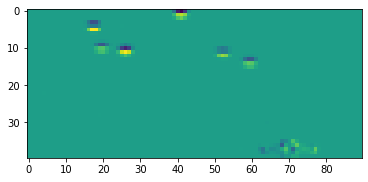

In [9]:
batch_size = 100
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
episode_durations = []
s=0
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    #plt.imshow(state)
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            #print('memory ready'+str(s))
            s+=1
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            #print(next_states.shape)
           # print(rewards)
           # print(actions)
            
            #print(states[0].shape)
            plt.imshow(  states[1].permute(1, 2, 0)  )
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            print('episode done')
         #   episode_durations.append(timestep)
          #  plot(episode_durations, 100)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()   